# Tensorflow

After using Numpy to build neural networks, now we will explore a deep learning framework that facilitates the implementation of DL algorithms. Machine learning frameworks like TensorFlow, PaddlePaddle, Torch, Caffe, Keras, and many others can speed up your machine learning development significantly. TensorFlow 2.3 has made significant improvements over its predecessor, some of which we'll encounter and implement here!

This frameworks not only cut down on time spent coding, but can also perform optimizations that speed up the code itself. 

## Librarys

In [99]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.16.1'

## Basic Optimization with GradientTape

The beauty of TensorFlow 2 is in its simplicity. Basically, all that is needed to do is implement forward propagation through a computational graph. TensorFlow will compute the derivatives for you, by moving backwards through the graph recorded with `GradientTape`. All that's left to do then is specify the cost function and optimizer to use. 

When writing a TensorFlow program, the main object to get used and transformed is the `tf.Tensor`. These tensors are the TensorFlow equivalent of Numpy arrays, i.e. multidimensional arrays of a given data type that also contain information about the computational graph.

Below, we use `tf.Variable` to store the state of your variables. Variables can only be created once as its initial value defines the variable shape and type. Additionally, the `dtype` arg in `tf.Variable` can be set to allow data to be converted to that type. But if none is specified, either the datatype will be kept if the initial value is a Tensor, or `convert_to_tensor` will decide. It's generally best to specify directly, so nothing breaks.

In [100]:
def linear_function(W, X, b):
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- Y = WX + b 
    """

    np.random.seed(1)

#     X = tf.constant(np.random.randn(3, 1), name = "X")
#     W = tf.constant(np.random.randn(4, 3), name = "W")
#     b = tf.constant(np.random.randn(4, 1), name = "X")
    
    Y = tf.add(tf.matmul(W, X), b)
    
    return Y

## Activation Functions

In [101]:
def sigmoid(z):
    
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    a -- (tf.float32) the sigmoid of z
    """

    z = tf.cast(z , tf.float32)
    a = tf.keras.activations.sigmoid(z)

    return a

## One hot

In [102]:
def one_hot_matrix(label, C=6):
    """
    Computes the one hot encoding for a single label

    Arguments:
        label --  (int) Categorical labels
        C --  (int) Number of different classes that label can take
    
    Returns:
         one_hot -- tf.Tensor A one-dimensional tensor (array) with the one hot encoding.
    """

    one_hot = tf.one_hot(label, depth=C)
    
    return one_hot

## Initialize the parameters

The function below takes in a shape and returns an array of numbers using the GlorotNormal initializer.

In [103]:
def initialize_parameters(input_size):
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, input_size]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Arguments:
    input_size -- size of the input feature vector
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   

    W1 = tf.Variable(initializer(shape=(25, input_size)))
    b1 = tf.Variable(initializer(shape=(25, 1)))
    W2 = tf.Variable(initializer(shape=(12, 25)))
    b2 = tf.Variable(initializer(shape=(12, 1)))
    W3 = tf.Variable(initializer(shape=(9, 12)))
    b3 = tf.Variable(initializer(shape=(9, 1)))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters


## Forward propagation

In [104]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                            # Numpy Equivalents (NumPy not to be used. Use TF API):
    Z1 = tf.add(tf.matmul(W1, X), b1)       # Z1 = np.dot(W1, X) + b1
    A1 = tf.keras.activations.relu(Z1)      # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)      # Z2 = np.dot(W2, A1) + b2
    A2 = tf.keras.activations.relu(Z2)      # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)      # Z3 = np.dot(W3, A2) + b3
    
    return Z3

### Compute the Total Loss

For our case, since we have a multi classification problem, a categorical cross entropy will be used.

Before we used to compute the cost value which sums the losses over the whole batch (i.e. all mini-batches) of samples, then divide the sum by the total number of samples. Here, you will achieve this in two steps. 

In step 1, the `compute_total_loss` function will only take care of summing the losses from one mini-batch of samples. Then, as you train the model by calling the `compute_total_loss` function once per mini-batch, step 2 will be done by accumulating the sums from each of the mini-batches, and finishing it with the division by the total number of samples to get the final cost value.

Computing the "total loss" instead of "mean loss" in step 1 can make sure the final cost value to be consistent. For example, if the mini-batch size is 4 but there are just 5 samples in the whole batch, then the last mini-batch is going to have 1 sample only. Considering the 5 samples, losses to be [0, 1, 2, 3, 4] respectively, we know the final cost should be their average which is 2. Adopting the "total loss" approach will get us the same answer. However, the "mean loss" approach will first get us 1.5 and 4 for the two mini-batches, and then finally 2.75 after taking average of them, which is different from the desired result of 2. Therefore, the "total loss" approach is adopted here. 

To compute the loss: 
- The "`y_pred`" and "`y_true`" inputs of [tf.keras.losses.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy) are expected to be of shape (number of examples, num_classes). 

- `tf.reduce_sum` does the summation over the examples.

- We skipped applying "softmax" in `forwad_propagation` because now it will be taken care by the `tf.keras.losses.categorical_crossentropy` by setting its parameter `from_logits=True` (Explanation by one the DeepLearning.AI mentors [here](https://community.deeplearning.ai/t/week-3-assignment-compute-total-loss-try-to-set-from-logits-false/243049/2?u=paulinpaloalto) in the Community for the mathematical reasoning behind it. If you are not part of the Community already, you can do so by going [here](https://www.coursera.org/learn/deep-neural-network/ungradedLti/ZE1VR/important-have-questions-issues-or-ideas-join-our-community).)

In [105]:
# Dentro da função compute_total_loss
def compute_total_loss(logits, labels):
    """
    Computes the total loss
    
    Arguments:
    logits -- logits, output of the forward propagation (input of the final layer), shape (batch_size, num_classes)
    labels -- true "label" vector (containing 0 if non-cat, 1 if cat), shape (batch_size, num_classes)
    
    Returns:
    total_loss - Tensor of the total loss value
    """
    # Transpose both logits and labels if needed
    logits_transposed = tf.transpose(logits)
    labels_transposed = tf.transpose(labels)

    # Compute categorical crossentropy loss
    loss = tf.keras.losses.categorical_crossentropy(labels_transposed, logits_transposed, from_logits=True)
    
    total_loss = tf.reduce_sum(loss)
    
    return total_loss


**Note:** When using sum of losses for gradient computation, it’s important to reduce the learning rate as the size of the mini-batch increases. This ensures that we don’t take large steps towards minimum.

### Training the Model

From the optimizers available, we need to specify the type of optimizer in one line, in this case `tf.keras.optimizers.Adam` (though you can use others such as SGD), and then call it within the training loop. 

Notice the `tape.gradient` function: this allows to retrieve the operations recorded for automatic differentiation inside the `GradientTape` block. Then, calling the optimizer method `apply_gradients`, will apply the optimizer's update rules to each trainable parameter. For more information, review the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape).


One extra step that's been added to the batch training process is: 

- `tf.Data.dataset = dataset.prefetch(8)` 

What this does is prevent a memory bottleneck that can occur when reading from disk. `prefetch()` sets aside some data and keeps it ready for when it's needed. It does this by creating a source dataset from the input data, applying a transformation to preprocess the data, then iterating over the dataset the specified number of elements at a time. This works because the iteration is streaming, so the data doesn't need to fit into the memory. 

In [106]:
from dataset_utils import CIFAR10Dataset

cifar10_path = 'datasets//cifar-10-batches-py/'

classifier_multiclass = CIFAR10Dataset(cifar10_path, classification_type='multiclass', num_train_exem=3000, num_test_exem=600)

# train_data_ds, train_labels_ds = classifier_multiclass.get_train_data(as_dataset=True)
# test_data_ds, test_labels_ds = classifier_multiclass.get_test_data(as_dataset=True)


In [107]:
train_data, train_labels = classifier_multiclass.get_train_data(as_dataset=False)
test_data, test_labels = classifier_multiclass.get_test_data(as_dataset=False)

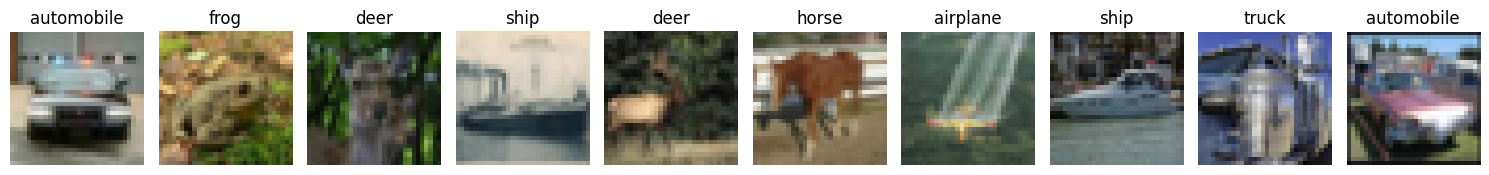

In [108]:
classifier_multiclass.plot_random_images(10, data_type='test', label='all')

In [109]:
m_train = train_data.shape[0]
num_px = train_data.shape[1]
m_test = test_data.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_data shape: " + str(train_data.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_data shape: " + str(test_data.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training examples: 3000
Number of testing examples: 600
Each image is of size: (3072, 3072, 3)
train_data shape: (3000, 3072)
train_labels shape: (3000,)
test_data shape: (600, 3072)
test_labels shape: (600,)


In [110]:
# Reshape the training and test examples 
train_x_flatten = train_data.T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_data.T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (3072, 3000)
test_x's shape: (3072, 600)


In [111]:
# m_train = tf.data.experimental.cardinality(train_data_ds).numpy()
# num_px = next(iter(train_data_ds)).shape[0]
# m_test = tf.data.experimental.cardinality(test_data_ds).numpy()

# print("Number of training examples: " + str(m_train))
# print("Number of testing examples: " + str(m_test))
# print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
# print("train_data shape: " + str((m_train, num_px, num_px, 3)))
# print("train_labels shape: " + str((m_train,)))
# print("test_data shape: " + str((m_test, num_px, num_px, 3)))
# print("test_labels shape: " + str((m_test,)))

In [112]:
train_x = tf.data.Dataset.from_tensor_slices(train_data)
test_x = tf.data.Dataset.from_tensor_slices(test_data)

In [114]:
# # # Reshape the training and test examples 
# train_data_ds_transposed = tf.data.Dataset.from_tensor_slices(train_data_ds.map(lambda x: tf.transpose(x)))
# test_data_ds_transposed = test_data_ds.map(lambda x: tf.transpose(x))

In [115]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost
    train_acc = []
    test_acc = []
    
    # Initialize your parameters
    #(1 line)
    input_size = 3072
    parameters = initialize_parameters(input_size)

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    # The CategoricalAccuracy will track the accuracy for this multiclass problem
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    # We can get the number of elements of a dataset using the cardinality method
    m = dataset.cardinality().numpy()
    
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
    #X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    #Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_total_loss = 0.
        
        #We need to reset object to start measuring from 0 the accuracy each epoch
        train_accuracy.reset_state()
        
        for (minibatch_X, minibatch_Y) in minibatches:
            
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                
                # 2. loss
                minibatch_total_loss = compute_total_loss(Z3, tf.transpose(minibatch_Y))

            # We accumulate the accuracy of all the batches
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_total_loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_total_loss += minibatch_total_loss
        
        # We divide the epoch total loss over the number of samples
        epoch_total_loss /= m

        # Print the cost every 10 epochs
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_total_loss))
            print("Train accuracy:", train_accuracy.result())
            
            # We evaluate the test set every 10 epochs to avoid computational overhead
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())

            costs.append(epoch_total_loss)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_state()


    return parameters, costs, train_acc, test_acc

In [116]:
test_y = one_hot_matrix(train_labels, max(train_labels))
test_y

<tf.Tensor: shape=(3000, 9), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [117]:
train_y = one_hot_matrix(test_labels, max(test_labels))
train_y

<tf.Tensor: shape=(600, 9), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [118]:
train_y = tf.data.Dataset.from_tensor_slices(train_y)
test_y = tf.data.Dataset.from_tensor_slices(test_y)

In [119]:
# Convertendo os dados de treino e teste para float32
train_x = train_x.map(lambda x: tf.cast(x, tf.float32))
test_x = test_x.map(lambda x: tf.cast(x, tf.float32))

In [123]:
parameters, costs, train_acc, test_acc = model(train_x, train_y, test_x, test_y, learning_rate=0.00001, num_epochs=100)

Cost after epoch 0: 70.677925
Train accuracy: tf.Tensor(0.095, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.093333334, shape=(), dtype=float32)
Cost after epoch 10: 4.296676
Train accuracy: tf.Tensor(0.096666664, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.13166666, shape=(), dtype=float32)
Cost after epoch 20: 2.583911
Train accuracy: tf.Tensor(0.09833334, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.13166666, shape=(), dtype=float32)
Cost after epoch 30: 2.296266
Train accuracy: tf.Tensor(0.105, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.13333334, shape=(), dtype=float32)
Cost after epoch 40: 2.154521
Train accuracy: tf.Tensor(0.11, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.135, shape=(), dtype=float32)
Cost after epoch 50: 2.086146
Train accuracy: tf.Tensor(0.11, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.13666667, shape=(), dtype=float32)
Cost after epoch 60: 2.046032
Train accuracy: tf.Tensor(0.11, shape=(), dtype=float32)
Test_acc

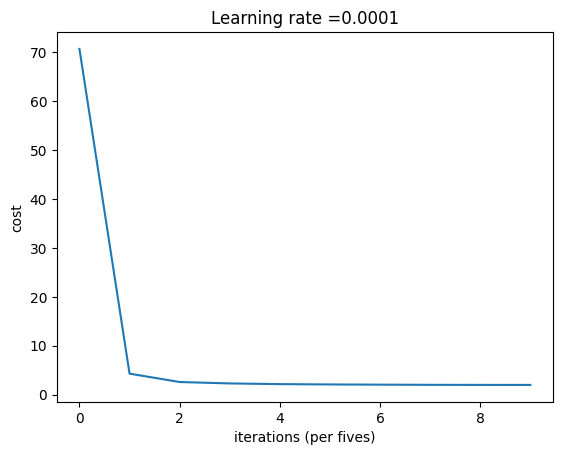

In [124]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()


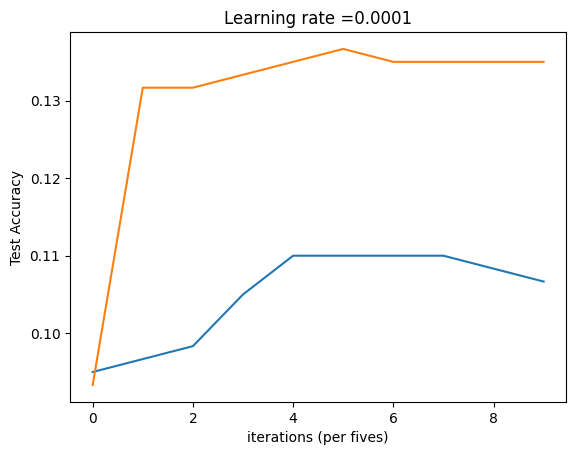

In [125]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()
